In [3]:
#### Import de libraries
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import functions 
import scipy.stats as stats
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [4]:
# import de la base de données excel
warnings.filterwarnings("ignore")
# data = pd.read_excel('sci.xlsx')
# data.to_parquet('df_sci.gzip', compression='gzip') 

In [5]:
df = pd.read_parquet("df_sci.gzip")

In [6]:
# df= data.copy()
df.info()
# Jeu de données initial avec 67 colonnes et 495514 lignes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495514 entries, 0 to 495513
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_client                    495514 non-null  int64         
 1   DDefaut_NDB                  495514 non-null  int64         
 2   datdelhis                    495514 non-null  int64         
 3   AGEPRS                       495514 non-null  int64         
 4   ANCIENNETE                   495514 non-null  int64         
 5   CODETAJUR                    495514 non-null  int64         
 6   CODITDBDF_PRO                495514 non-null  int64         
 7   CODNAF2                      495514 non-null  object        
 8   CODTYPPRS                    495514 non-null  int64         
 9   CRTAD_AG_MVTAFF_IND_0010     495514 non-null  int64         
 10  CRTAD_AG_NBECR_A             495514 non-null  int64         
 11  CRTAD_AG_NBECR_B          

### 0. Vérifications préliminaires

On aurait pu également regrouper les informations sur le pays de résidence ou de naissance en résident UE ou non UE car le RGPD nous permet. Cependant, elles ne seraient pas très utiles dans la prédiction car ce sont des variables très sureprésentées dans les données.

In [7]:
# Suppression des variables illégales
var_illegales = ['CODPAY_NAISSANCE', 'CODPAY_NATIONALITE','CODSEXPRS','CODCMNIEE','CODPAY_RESIDENCE']
df.drop(columns=var_illegales,inplace=True)

#=> 62 colonnes

In [8]:
# Vérification des doublons par ligne dans la base de données
print(df.duplicated().sum())

0


In [9]:
# Vérification des doublons par colonnes
all(df['CRTAD_AG_SOLDE_T']==df["CRTAE_AG_SLDEPA"])

False

In [10]:
print(f"{all(df['DATCREENT'==df['DATCREPRSENT']])=}")
df.drop(columns=['DATCREPRSENT'],inplace=True)
#=> 61 colonnes

all(df['DATCREENT'==df['DATCREPRSENT']])=True


##### Identification des variables explicatives catégorielles et des variables numériques

In [11]:
importlib.reload(functions)

# Affichage des variables ayant un nombre de valeurs uniques inférieurs à 30 
# Le seuil de 30 est arbitraire
# retrait de variables date et defaut
result_df= functions.find_categorical_variables(df, 30)

----------------------------------------
Nombre total de variables ayant moins de 30 modalités : 19 

----------------------------------------
                  Variable  Unique_Count
10               DATCREENT             0
9   CRTOU_CCT_PRO_IND_0209             1
15               IND_ACTIF             1
14           TOP_PRO_ACTIF             1
13                  RATIO3             1
12                  RATIO1             1
11               INDPARDCD             1
17        secteur_activite             1
18    secteur_activite_bis             1
7        CRTOP_AG_IND_0038             1
6   CRTOD_CMT_PRO_IND_0209             1
8           CRTOP_IND_0038             1
4                CODTYPPRS             2
2            CODITDBDF_PRO             2
16              IND_PER_PM             2
0              DDefaut_NDB             2
3                  CODNAF2             4
1                datdelhis             6
5           CRTAD_IND_0062             7
-------------------------------------

In [12]:
# Retrait de la variable CRTAD_IND_0062 car elle est quantitative discrète 
# Retrait des variables date et defaut, car ce ne sont pas des variables explicatives
# et des variables n'ayant qu'une modalité
pre_categorical_vars = [ col for col in result_df["Variable"][result_df["Unique_Count"]>=2]
                     if col not in ["CRTAD_IND_0062", "datdelhis", "DDefaut_NDB"]]
print(pre_categorical_vars)

for col in pre_categorical_vars:
    print(f"{col} : {df[col].dtypes}")


# Transformation des variables catégorielles en variables catégorielles
df[pre_categorical_vars] = df[pre_categorical_vars].astype('category')

['CODITDBDF_PRO', 'CODNAF2', 'CODTYPPRS', 'IND_PER_PM']
CODITDBDF_PRO : int64
CODNAF2 : object
CODTYPPRS : int64
IND_PER_PM : object


In [13]:
# Variables à exclure car elles n'ont qu'une modalité
vars_to_exclude = result_df["Variable"][result_df["Unique_Count"] <= 1].tolist() 

# Variables continues
pre_cont_vars = [col for col in df.columns if col not in (pre_categorical_vars + vars_to_exclude + ['id_client', 'DDefaut_NDB', 'datdelhis'])]
print(len(pre_cont_vars))

42


##### Identification des variables à une modalité au plus pour description des individus de la bdd

Notre jeu de données est constitué de SCI, ayant un indicateur actif = 0, avec des Montant des litiges (CRTOD_CMT_PRO_IND_0209), Somme des soldes moyens trimestre (m a m-2), soldes moyen (CRTOP_AG_IND_0038), cumul de litiges (CRTOU_CCT_PRO_IND_0209), Solde en jours de mouvement d'affaire (Ratio 1) et  Solde débiteur cumulé rapporté au mouvement d'affaire (Ratio 3) nuls.

In [14]:
for col in vars_to_exclude:
    print(f"{col} : {df[col].unique()}")

CRTOD_CMT_PRO_IND_0209 : [0]
CRTOP_AG_IND_0038 : [0]
CRTOP_IND_0038 : [0]
CRTOU_CCT_PRO_IND_0209 : [0]
DATCREENT : [nan]
INDPARDCD : [ 0. nan]
RATIO1 : [0]
RATIO3 : [0]
TOP_PRO_ACTIF : ['O']
IND_ACTIF : [1]
secteur_activite : ['SCI']
secteur_activite_bis : ['SCI']


In [15]:
# Retrait des variables n'apportant aucune information pour la prédiction (car à modalités uniques) 
df.drop(columns=vars_to_exclude ,inplace=True)
# => 59 colonnes

In [16]:
print("Database après les modifications ")
df.info()
# Jeu de données avec 59 colonnes et 495514 lignes.

Database après les modifications 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495514 entries, 0 to 495513
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   id_client                    495514 non-null  int64   
 1   DDefaut_NDB                  495514 non-null  int64   
 2   datdelhis                    495514 non-null  int64   
 3   AGEPRS                       495514 non-null  int64   
 4   ANCIENNETE                   495514 non-null  int64   
 5   CODETAJUR                    495514 non-null  int64   
 6   CODITDBDF_PRO                495514 non-null  category
 7   CODNAF2                      495514 non-null  category
 8   CODTYPPRS                    495514 non-null  category
 9   CRTAD_AG_MVTAFF_IND_0010     495514 non-null  int64   
 10  CRTAD_AG_NBECR_A             495514 non-null  int64   
 11  CRTAD_AG_NBECR_B             495514 non-null  int64   
 12  CRTAD_AG_N

# I. Identification de la variable cible et analyse des variables explicatives

## I.1. La variable cible 

In [17]:
cible = "DDefaut_NDB"
print("Type of target column")
print(df[[cible]].dtypes)

Type of target column
DDefaut_NDB    int64
dtype: object


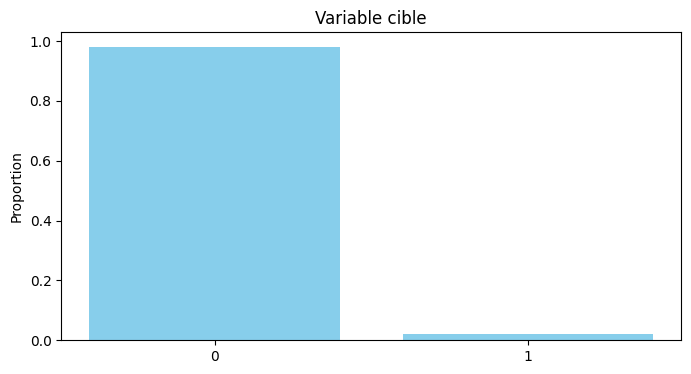

In [18]:
# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(df[cible].value_counts().index.astype(str), df[cible].value_counts(normalize=True), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [19]:
#Transformer le format de date :
date = "datdelhis"
print("Nombre de dates : ",df[['datdelhis']].nunique())
print("Format de date initial: ", df[['datdelhis']].dtypes)


df['datdelhis'] = pd.to_datetime(df['datdelhis'], format = '%Y%m')
print("Format de date final: ", df[['datdelhis']].dtypes)


Nombre de dates :  datdelhis    6
dtype: int64
Format de date initial:  datdelhis    int64
dtype: object
Format de date final:  datdelhis    datetime64[ns]
dtype: object


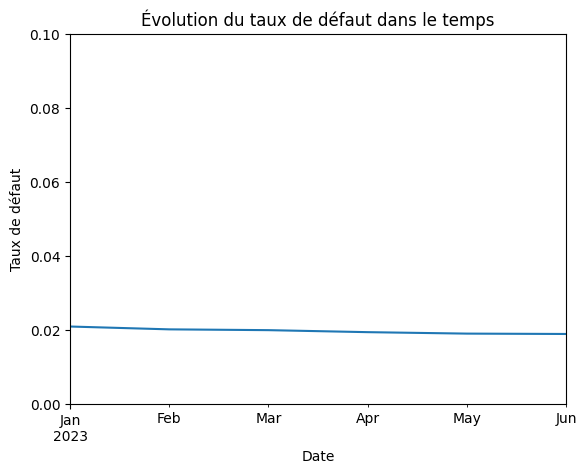

In [20]:
# Evolution de la variable cible dans le temps

taux_cible = df.groupby(df['datdelhis'].dt.to_period('M'))['DDefaut_NDB'].mean() # ou sum()

# Tracer le taux de la variable cible au fil du temps
taux_cible.plot(title='Évolution du taux de défaut dans le temps')
plt.xlabel('Date')
plt.ylabel('Taux de défaut')
plt.ylim(0,0.1)
plt.show()

## I.2. Construction de la base d'échantillon

In [21]:
# Identification des variables catégorielles pouvant générer un biais de sélection dans le modèle
# Ces variables n'apportent aucune information pour la prédition de la variable cible car elles ne sont pas discrimantes

importlib.reload(functions)
df_var_surep = functions.find_uniq_mod_variables(df, pre_categorical_vars, 0.99)
var_surep = [col for col in df_var_surep["Variable"] if col not in ["DDefaut_NDB"]]

# retrait des variables surepresentées 
pre_categorical_vars = [col for col in pre_categorical_vars if col not in var_surep]

----------------------------------------
Nombre de variables ayant une modalité dominante à plus de 99.0% : 3
----------------------------------------
        Variable  Nb_mod Mod_dominante  Frequence
0  CODITDBDF_PRO       2             0   0.996587
1      CODTYPPRS       2             2   0.994987
2     IND_PER_PM       2            PM   0.994987
----------------------------------------


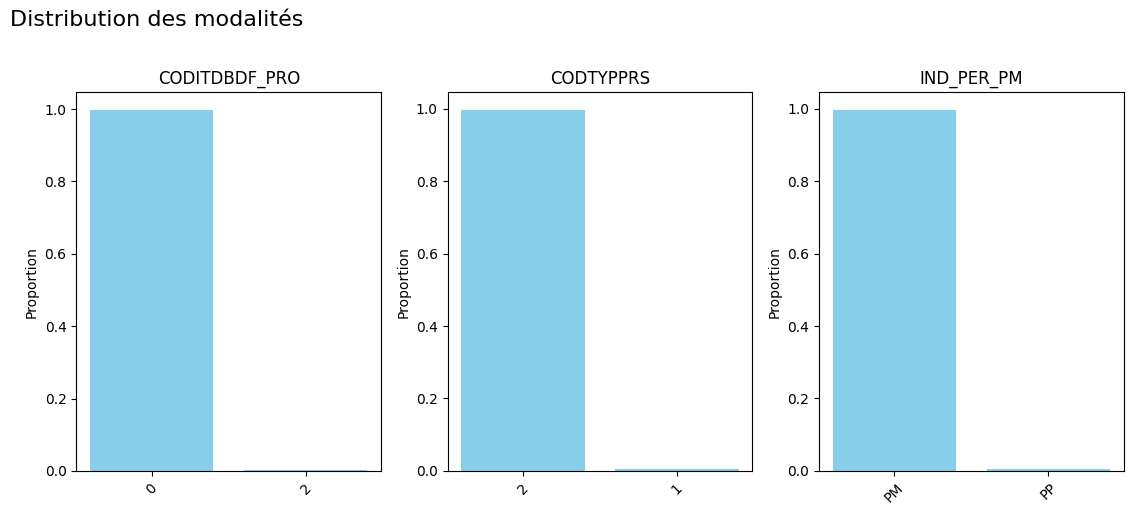

In [22]:
# Create the bar plot
importlib.reload(functions)
functions.plot_cat_vars_distributions(df, var_surep,cols=4)

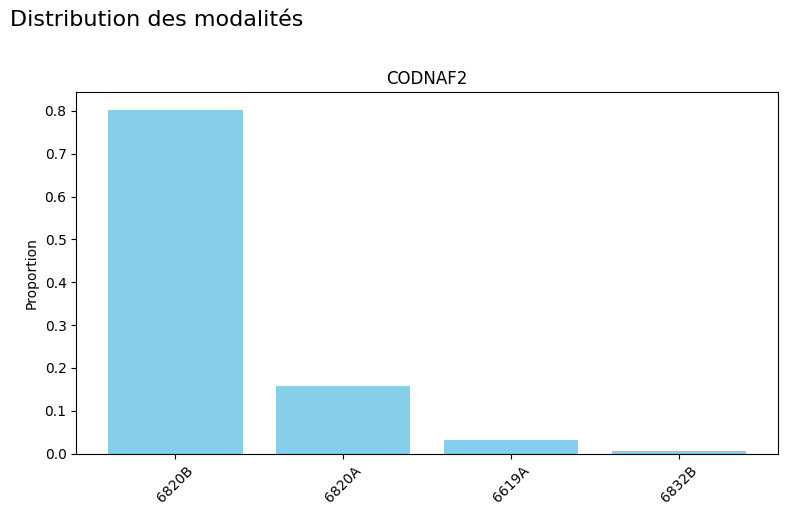

In [23]:
# Analyse des autres variables catégorielles
importlib.reload(functions)
functions.plot_cat_vars_distributions(df, [col for col in pre_categorical_vars if col not in var_surep], cols=2)

# Il n'y a que la variable CODNAF_2 qui n'a pas de modalité sureprésentée, cependant les classes sont déséquilibrées, il faudrait donc l'utiliser pour la stratification des données

In [24]:
## Creation des echantillons train et test 

# Retrait des mauvaises variables de prédictions (variables ne prenant pratiquement qu'une seule modalité)
df_copy = df.copy()
X = df_copy.drop(columns = var_surep)
y = df_copy[cible]
X['stratify_col'] = df_copy[cible].astype(str) + '_' + df_copy['datdelhis'].astype(str) + '_' +  df_copy['CODNAF2'].astype(str) 

# Split train-test stratifié en utilisant la colonne combinée
X_train, X_test, y_train, y_test = train_test_split(
    X,  y,
    stratify=X['stratify_col'],  # La nouvelle colonne pour la stratification
    test_size=0.2,                # La proportion de l'ensemble de test
    random_state=42               # La graine pour la reproductibilité
)


In [25]:
df_copy.shape

(495514, 49)

In [26]:
X_train.shape

(396411, 47)

In [27]:
X_test.shape

(99103, 47)

In [28]:
# Suppression de la colonne de stratification car non utile pour la suite
X_train = X_train.drop(['stratify_col'], axis=1)
X_test = X_test.drop(['stratify_col'], axis=1)

#### I.2.1 Analyse de la représentativité des variables 

##### Variables ayant servis à la stratification

In [29]:
# Vérification de la répartition de la variable cible dans le train et le test

print("Répartition de la cible dans le train :")
print(y_train.value_counts(normalize=True))

print("\nRépartition de la cible dans le test :")
print(y_test.value_counts(normalize=True))


Répartition de la cible dans le train :
0    0.980374
1    0.019626
Name: DDefaut_NDB, dtype: float64

Répartition de la cible dans le test :
0    0.980374
1    0.019626
Name: DDefaut_NDB, dtype: float64


In [30]:
#### On verifie que la repartition des elements ayant servis à la stratification est la même dans nos echantillons train et test
# Vérification de la répartition des combinaisons dans la colonne de stratification

print("Répartition relative des dates d'observation dans le train :")
print(X_train['datdelhis'].value_counts(normalize=True))

print("\nRépartition relative des dates d'observation dans le test :")
print(X_test['datdelhis'].value_counts(normalize=True))



Répartition relative des dates d'observation dans le train :
2023-06-01    0.168388
2023-05-01    0.167720
2023-04-01    0.167236
2023-03-01    0.166620
2023-02-01    0.166040
2023-01-01    0.163996
Name: datdelhis, dtype: float64

Répartition relative des dates d'observation dans le test :
2023-06-01    0.168380
2023-05-01    0.167704
2023-04-01    0.167220
2023-03-01    0.166635
2023-02-01    0.166049
2023-01-01    0.164011
Name: datdelhis, dtype: float64


In [31]:
print("Répartition relative du secteur d'activité dans le train :")
print(X_train['CODNAF2'].value_counts(normalize=True))

print("\nRépartition relative du secteur d'activité dans le test :")
print(X_test['CODNAF2'].value_counts(normalize=True))

Répartition relative du secteur d'activité dans le train :
6820B    0.803028
6820A    0.157569
6619A    0.032411
6832B    0.006993
Name: CODNAF2, dtype: float64

Répartition relative du secteur d'activité dans le test :
6820B    0.803033
6820A    0.157584
6619A    0.032401
6832B    0.006983
Name: CODNAF2, dtype: float64


##### Variables continues

Analyses visuelles des distributions (KDE)


In [32]:
#### On peut également s'assurer que la distribution des variables continues est la même dans notre train et dans notre test 
#### Ce qui pourrait indiquer que notre stratification a capté l'ensemble des variables importantes.

### Nous avons donc choisi quelques variables que nous estimions pertinentes pour ce faire

# Liste des variables continues à analyser
var_a_analyser = ['AGEPRS','ANCIENNETE', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_SOLDE_IND_0009', 
                       'CRTAR_IND_0036', 'CRTAD_AG_NBJDE_BA', 'CRTAD_IND_0062']


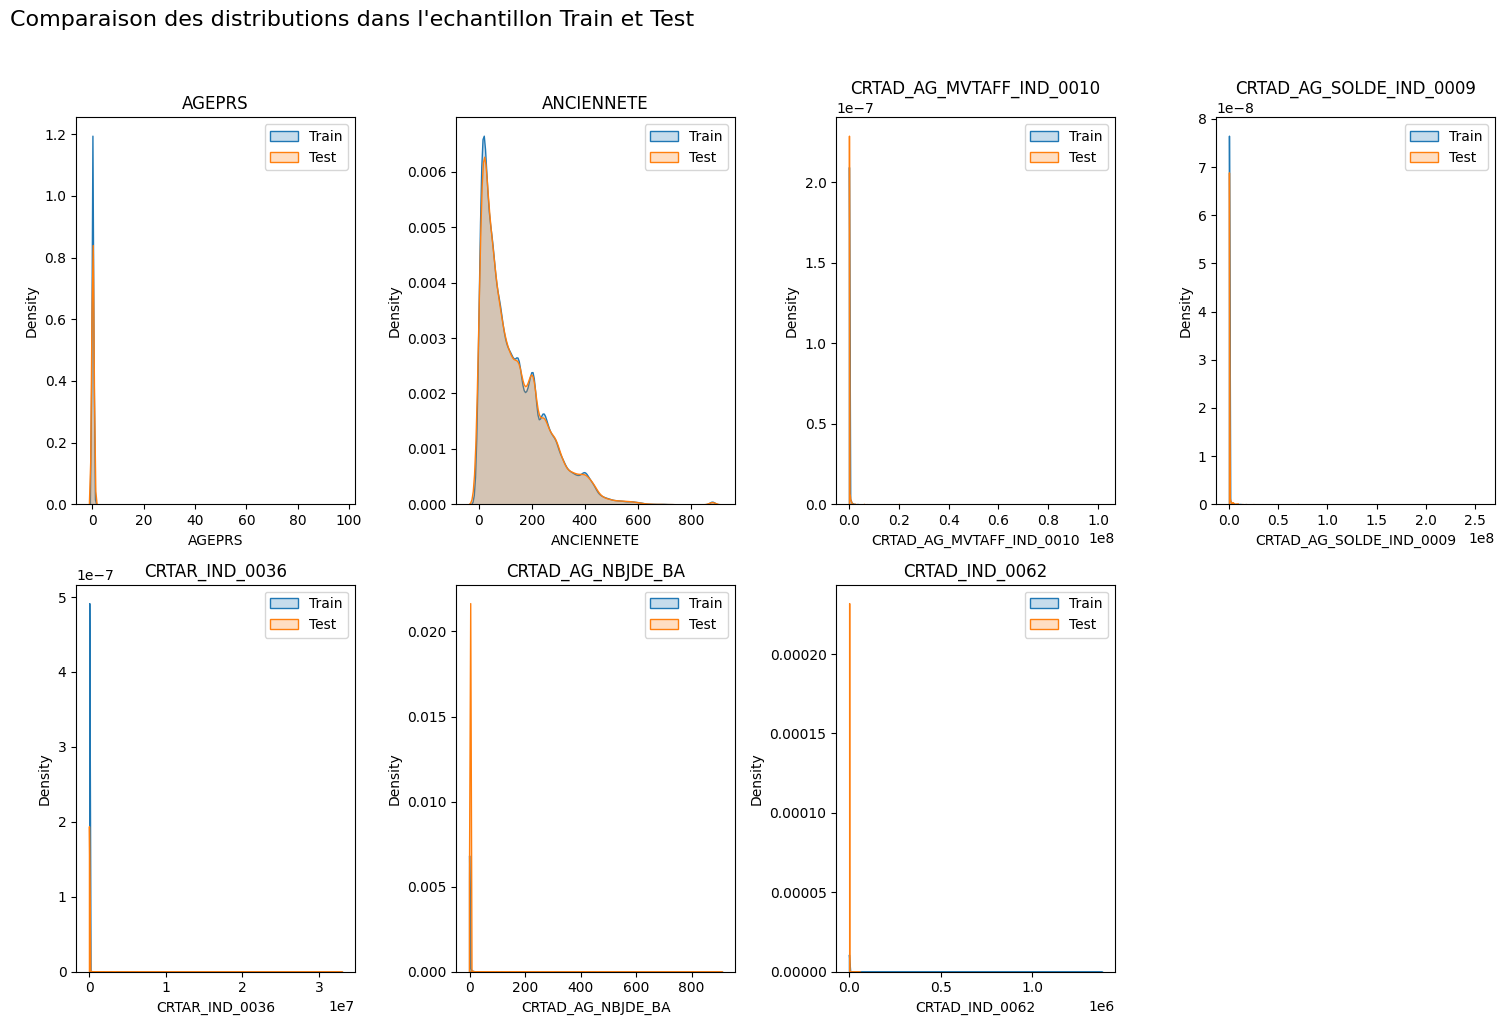

In [33]:
importlib.reload(functions)
functions.compare_distributions_grid(X_train, X_test, var_a_analyser, cols=4)

Analyse statistique de la représentativité

In [34]:
importlib.reload(functions)
functions.compare_distributions_summary(X_train, X_test, pre_cont_vars)

# Les distributions des variables continues sont similaires dans les échantillons train et test

,Variable,Train_Mean,Test_Mean,Train_Std,Test_Std,KS_Statistic,KS_p_value,Similar_Distribution
0,AGEPRS,3.003146e-01,3.199096e-01,4.372487e+00,4.545119e+00,0.000391,1.000000,Yes
1,ANCIENNETE,1.343660e+02,1.346389e+02,1.194232e+02,1.197109e+02,0.002933,0.501854,Yes
2,CODETAJUR,6.473105e+03,6.472619e+03,4.452317e+02,4.488154e+02,0.001060,0.999992,Yes
3,CRTAD_AG_MVTAFF_IND_0010,4.796051e+03,4.746626e+03,2.775689e+05,1.924476e+05,0.000174,1.000000,Yes
4,CRTAD_AG_NBECR_A,5.215597e-01,4.969981e-01,1.045736e+01,9.883302e+00,0.000199,1.000000,Yes
5,CRTAD_AG_NBECR_B,5.031899e-01,4.819228e-01,1.005405e+01,9.556310e+00,0.000207,1.000000,Yes
6,CRTAD_AG_NBJDE_BA,2.462520e-01,2.499420e-01,8.516190e+00,8.345475e+00,0.000164,1.000000,Yes
7,CRTAD_AG_NBJDE_BB,5.144660e-02,5.012966e-02,1.966218e+00,1.900597e+00,0.000053,1.000000,Yes
8,CRTAD_AG_NBJDE_BC,4.501893e-02,5.076537e-02,1.772380e+00,1.842274e+00,0.000177,1.000000,Yes
9,CRTAD_AG_SOLDE_IND_0009,1.592789e+04,1.563829e+04,7.595664e+05,6.391658e+05,0.000270,1.000000,Yes


## I.3. Création de nouveaux indicateurs et pré-sélection des variables candidates à l’explication de la variable cible

#### I.3.1 Pré-selection des variables
On s'assure que nos données soient fiables, homogènes dans le temps et cohérentes.
##### Fiabilité

In [36]:
### Fiables
# Calculer le taux de valeurs manquantes (en pourcentage) pour chaque colonne
missing_percentages = X_train.isna().mean() * 100

# Filtrer uniquement les colonnes avec des valeurs manquantes
missing_columns = missing_percentages[missing_percentages > 0]

# Afficher le nombre de colonnes avec des valeurs manquantes
print(f"Nombre de colonnes avec des valeurs manquantes : {len(missing_columns)}")

# Afficher le taux de valeurs manquantes uniquement pour ces colonnes
if len(missing_columns) > 0:
    print("\nTaux de valeurs manquantes par colonne (%):")
    print(missing_columns)


Nombre de colonnes avec des valeurs manquantes : 0


On éludera le traitement des outliers ici vu que l'on segmentera nos données plustard

##### Homogenéité temporelle

Verifions que nos données catégorielles sont homogènes dans le temps, qu'il n'y a pas apparition et disparition  d'une modalité par exemple


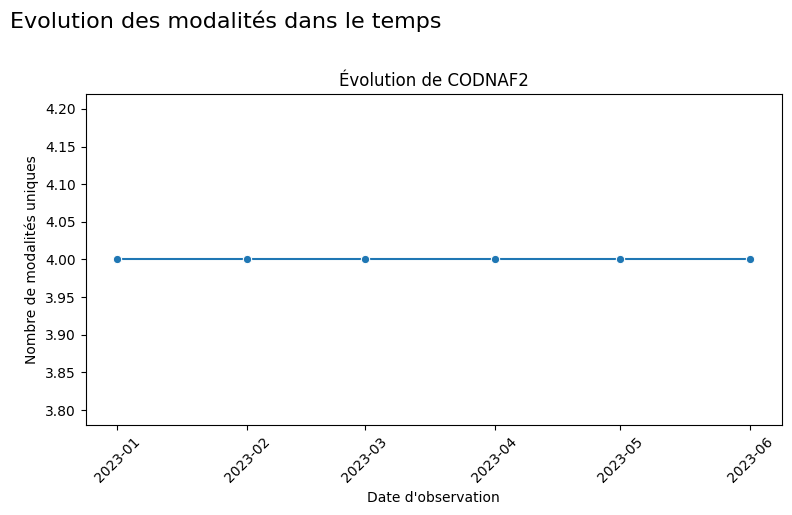

In [37]:
importlib.reload(functions)
functions.plot_modalities_over_time(X_train, "datdelhis", pre_categorical_vars)

##### Cohérences et pertinences des variables
On s'assure de la cohérence et de la pertinence des variables de notre base. Toues les variables sont pertinentes. Au niveau de l'ancienneté, il est possible d'avoir des sociétés avec 12 ans d'ancienneté.

#### I.3.2 Creation de nouveaux indicateurs

In [39]:
X_train['SECTNAF'] = X_train['CODNAF2'].str[-1]  ### On regroupe les secteurs d'activité en deux
#df["ANCENT"]= df['datdelhis'].dt.month - df['DATCREENT'].dt.month  ### On cree une nouvelle variable pour l'ancienneté de la SCI

X_train["CODETAJUR"] = X_train["CODETAJUR"].astype(str)
X_train['CODETAJUR_II'] = X_train["CODETAJUR"].str[0:2]
X_train['CODETAJUR_I'] = X_train["CODETAJUR"].str[0]

categorical_vars = pre_categorical_vars + ['SECTNAF', 'CODETAJUR_II', 'CODETAJUR_I']

#On a preférer regarder les niveaux 1 et 2 da la categorie juridique au sens insee 
# et supprimer le niveau 3 car elle a bien trop de modalités (72)
## cet indicateur ne pourra pas être calculé anyway
cont_vars = [var for var in pre_cont_vars if var != 'CODETAJUR']


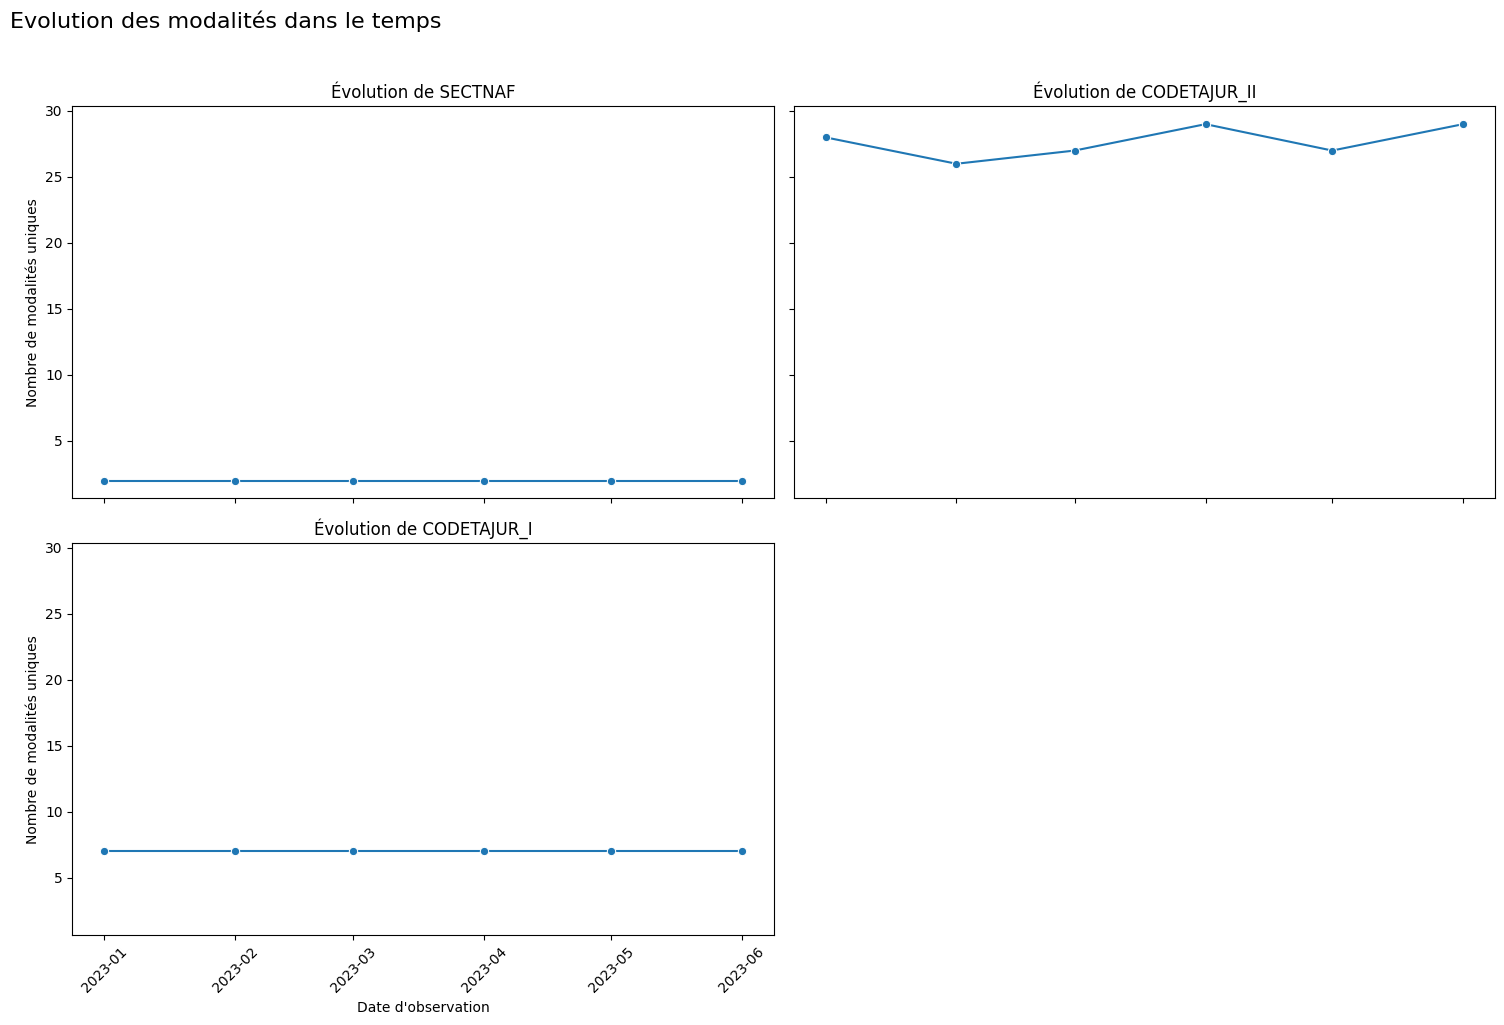

In [40]:
# Vérification de la cohérence temporelle des nouveaux indicateurs
importlib.reload(functions)
functions.plot_modalities_over_time(X_train, "datdelhis",  ['SECTNAF','CODETAJUR_II','CODETAJUR_I'])

# Attention, CODETAJUR_II n'est pas homogène dans le temps

In [41]:
#### Creation des indicateurs , ratios entre les indicateurs financiers courant et ceux d'il y a un an
# client avec plus de 1 an d'ancienneté
## Creer de nouvelles variables dans notre dataframe df correspondant aux ratios entre les deux variables

temp_df = pd.DataFrame()

temp_df[cible] = X_train[cible].values
temp_df[date] = X_train[date].values
temp_df['id_client'] = X_train['id_client'].values
# Évolution du nombre de jours d'écritures en jours
temp_df['evol_NBECR'] =np.where(
    X_train['CRTAD_AG_NBECR_B'] != 0, 
    (X_train['CRTAD_AG_NBECR_A'] - X_train['CRTAD_AG_NBECR_B'])/  X_train['CRTAD_AG_NBECR_B'],
    np.nan
    )

# Évolution du nombre de jours débiteurs en jours
temp_df['evol_NBJDE'] = np.where(
    X_train['CRTAD_AG_NBJDE_BC'] != 0,
    (X_train['CRTAD_AG_NBJDE_BB'] - X_train['CRTAD_AG_NBJDE_BC']) /  X_train['CRTAD_AG_NBJDE_BC'],
    np.nan
)

# Ratio nombre de jours débiteurs / nombre de jours créditeurs
temp_df['evol_line_deb_cr'] = np.where(
    X_train['CRTOC_AG_LIGCRE_2T_IND_0009'] != 0,
    X_train['CRTOC_AG_LIGDEB_2T_IND_0015'] / X_train['CRTOC_AG_LIGCRE_2T_IND_0009'],
    np.nan
)

# Ratio mouvement d'affaire / nbre de jours débiteurs
temp_df['ratio_ma_deb'] = np.where(
    X_train['CRTOC_IND_0015'] != 0,
    X_train['CRTOC_IND_0010'] / X_train['CRTOC_IND_0015'],
    np.nan
)

# Ratio dettes / encours
temp_df['ratio_deb_enc'] = np.where(
    X_train['CRTOD_CMT_IND_0036'] != 0,
    X_train['CRTOC_AG_LIGDEB_2T_IND_0015'] / X_train['CRTOD_CMT_IND_0036'],
    np.nan
)

# Ratio soldes créditeurs / mouvement d'affaire
temp_df['ratio_cred_ma'] = np.where(
    X_train['CRTOC_AG_MVTAFF_IND_0010'] != 0,
    X_train['CRTOC_AG_LIGCRE_IND_0009'] / X_train['CRTOC_AG_MVTAFF_IND_0010'],
    np.nan
)

new_vars = ['evol_NBECR', 'evol_NBJDE', 'evol_line_deb_cr', 'ratio_ma_deb','ratio_deb_enc', 'ratio_cred_ma']

In [43]:
# Vérifier le nombre de valeurs manquante pour les nouvelles variables
print(temp_df[new_vars].isna().mean())

#/!\ Attention, il y a des valeurs qui ont 99% de valeurs manquantes
var_a_dis = ['evol_line_deb_cr','ratio_cred_ma']

evol_NBECR          0.995575
evol_NBJDE          0.998411
evol_line_deb_cr    0.058823
ratio_ma_deb        0.910172
ratio_deb_enc       0.955203
ratio_cred_ma       0.095721
dtype: float64


In [44]:
# Discrétisation de variables avec outliers avec WoE

importlib.reload(functions)
X_train_dis, discretized_columns, non_discretized_columns=functions.discretize_with_iv_woe(temp_df, cible,date, var_a_dis,"id_client", bins=5, epsilon=1e-16)

--------------------------------------------

Information value of variable evol_line_deb_cr is 0.961871
Discrétisation de la colonne evol_line_deb_cr avec les bornes: [-1172291.838, -6.42e-06, 0.0]
--------------------------------------------

Information value of variable ratio_cred_ma is 0.485137
Discrétisation de la colonne ratio_cred_ma avec les bornes: [-0.001, 16.282, 37.831, 83.086, 211.347, 142178587.0]


In [45]:
importlib.reload(functions)

for col in var_a_dis:
    print(functions.iv_woe(temp_df[[col] + [cible]], cible))

--------------------------------------------

Information value of variable evol_line_deb_cr is 0.961871
(           Variable        IV
0  evol_line_deb_cr  0.961871,            Variable                     Cutoff       N  Events  % of Events  \
0  evol_line_deb_cr  (-1172291.838, -6.42e-06]   74619    3244     0.657212   
1  evol_line_deb_cr           (-6.42e-06, 0.0]  298474    1692     0.342788   

   Non-Events  % of Non-Events       WoE        IV  
0       71375         0.193871  1.220814  0.565653  
1      296782         0.806129 -0.855132  0.396218  )
--------------------------------------------

Information value of variable ratio_cred_ma is 0.485137
(        Variable        IV
0  ratio_cred_ma  0.485137,         Variable                  Cutoff      N  Events  % of Events  \
0  ratio_cred_ma        (-0.001, 16.282]  71694    2314     0.491504   
1  ratio_cred_ma        (16.282, 37.831]  71693     954     0.202634   
2  ratio_cred_ma        (37.831, 83.086]  71693     587     0

In [96]:
X_train_dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396411 entries, 0 to 396410
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   datdelhis             396411 non-null  datetime64[ns]
 1   DDefaut_NDB           396411 non-null  int64         
 2   id_client             396411 non-null  int64         
 3   evol_line_deb_cr_dis  373093 non-null  category      
 4   ratio_cred_ma_dis     358466 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 9.8 MB


In [47]:
X_train_dis.shape

(396411, 5)

In [48]:
# Vérifiez si la catégorie "missing" est déjà dans les catégories existantes
if 'missing' not in X_train_dis["evol_line_deb_cr_dis"].cat.categories:
    X_train_dis["evol_line_deb_cr_dis"] = X_train_dis["evol_line_deb_cr_dis"].cat.add_categories(["missing"])

# Remplir les valeurs manquantes avec "missing"
X_train_dis["evol_line_deb_cr_dis"].fillna("missing", inplace=True)


In [49]:
# Vérifiez si la catégorie "missing" est déjà dans les catégories existantes
if 'missing' not in X_train_dis["ratio_cred_ma_dis"].cat.categories:
    X_train_dis["ratio_cred_ma_dis"] = X_train_dis["ratio_cred_ma_dis"].cat.add_categories(["missing"])

# Remplir les valeurs manquantes avec "missing"
X_train_dis["ratio_cred_ma_dis"].fillna("missing", inplace=True)


In [50]:
X_train_dis.shape

(396411, 5)

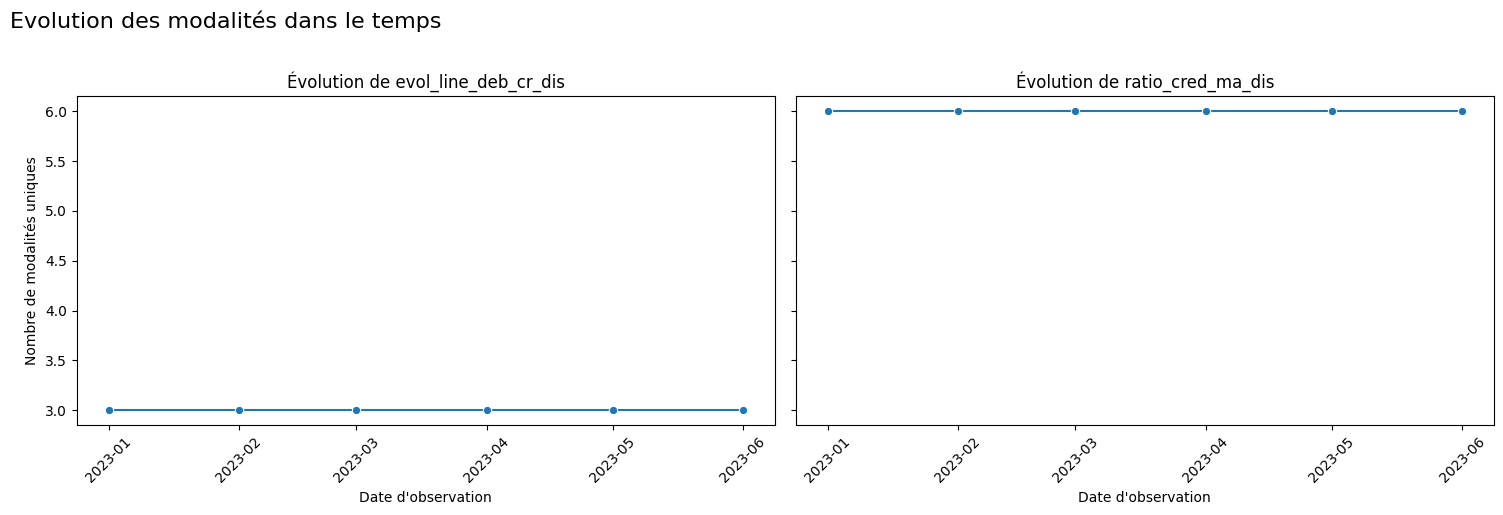

In [51]:
# Vérification de la cohérence temporelle des nouveaux indicateurs
importlib.reload(functions)
functions.plot_modalities_over_time(X_train_dis, "datdelhis", discretized_columns)

# On retient les variables discrétisées car elles sont homogènes dans le temps
categorical_vars = categorical_vars + discretized_columns
X_train_temp = X_train.copy()
#X_train = pd.merge(X_train_temp, X_train_dis[discretized_columns+['id_client']], left_on='id_client', right_on='id_client', how='inner')

# II- Selection des variables

Les variables catégorielles ont déja été traitées dans la partie précédente (au niveau de la stratification de la base)

In [81]:
#print(cont_vars)
#print(categorical_vars)
categorical_vars =['CODNAF2', 'SECTNAF', 'CODETAJUR_II', 'CODETAJUR_I','evol_line_deb_cr_dis','ratio_cred_ma_dis']



### II.1. Variables catégorielles
#### II.1.1 Statistiques descriptives pour les variables catégorielles

In [77]:
X_train['key'] = X_train['datdelhis'].astype(str) + '_' + X_train['id_client'].astype(str)
X_train_dis['key'] = X_train_dis['datdelhis'].astype(str) + '_' + X_train_dis['id_client'].astype(str)

In [80]:
X_train_dis_filtered = X_train_dis[['evol_line_deb_cr_dis', 'ratio_cred_ma_dis', 'key']]

X_train_combined = pd.merge(
    X_train,
    X_train_dis_filtered,
    on='key',
    how='inner'
)
#print(X_train_combined.head())  # Affiche les premières lignes
print(X_train_combined.shape)  # Taille du DataFrame résultant


(396411, 52)


In [82]:
X_train=X_train_combined

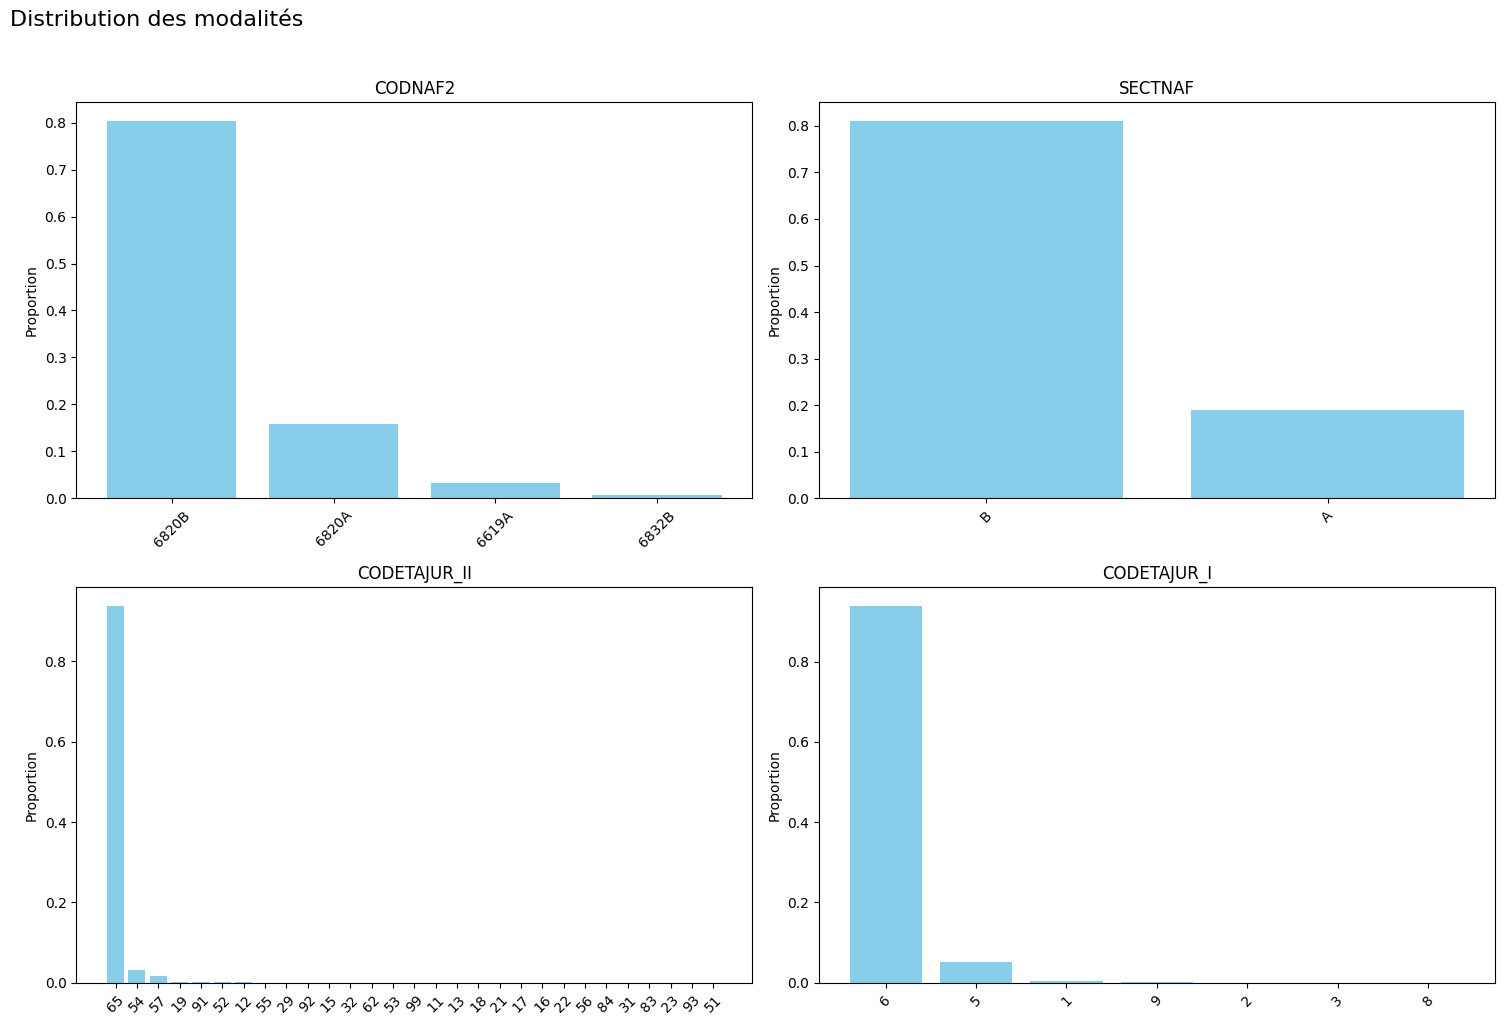

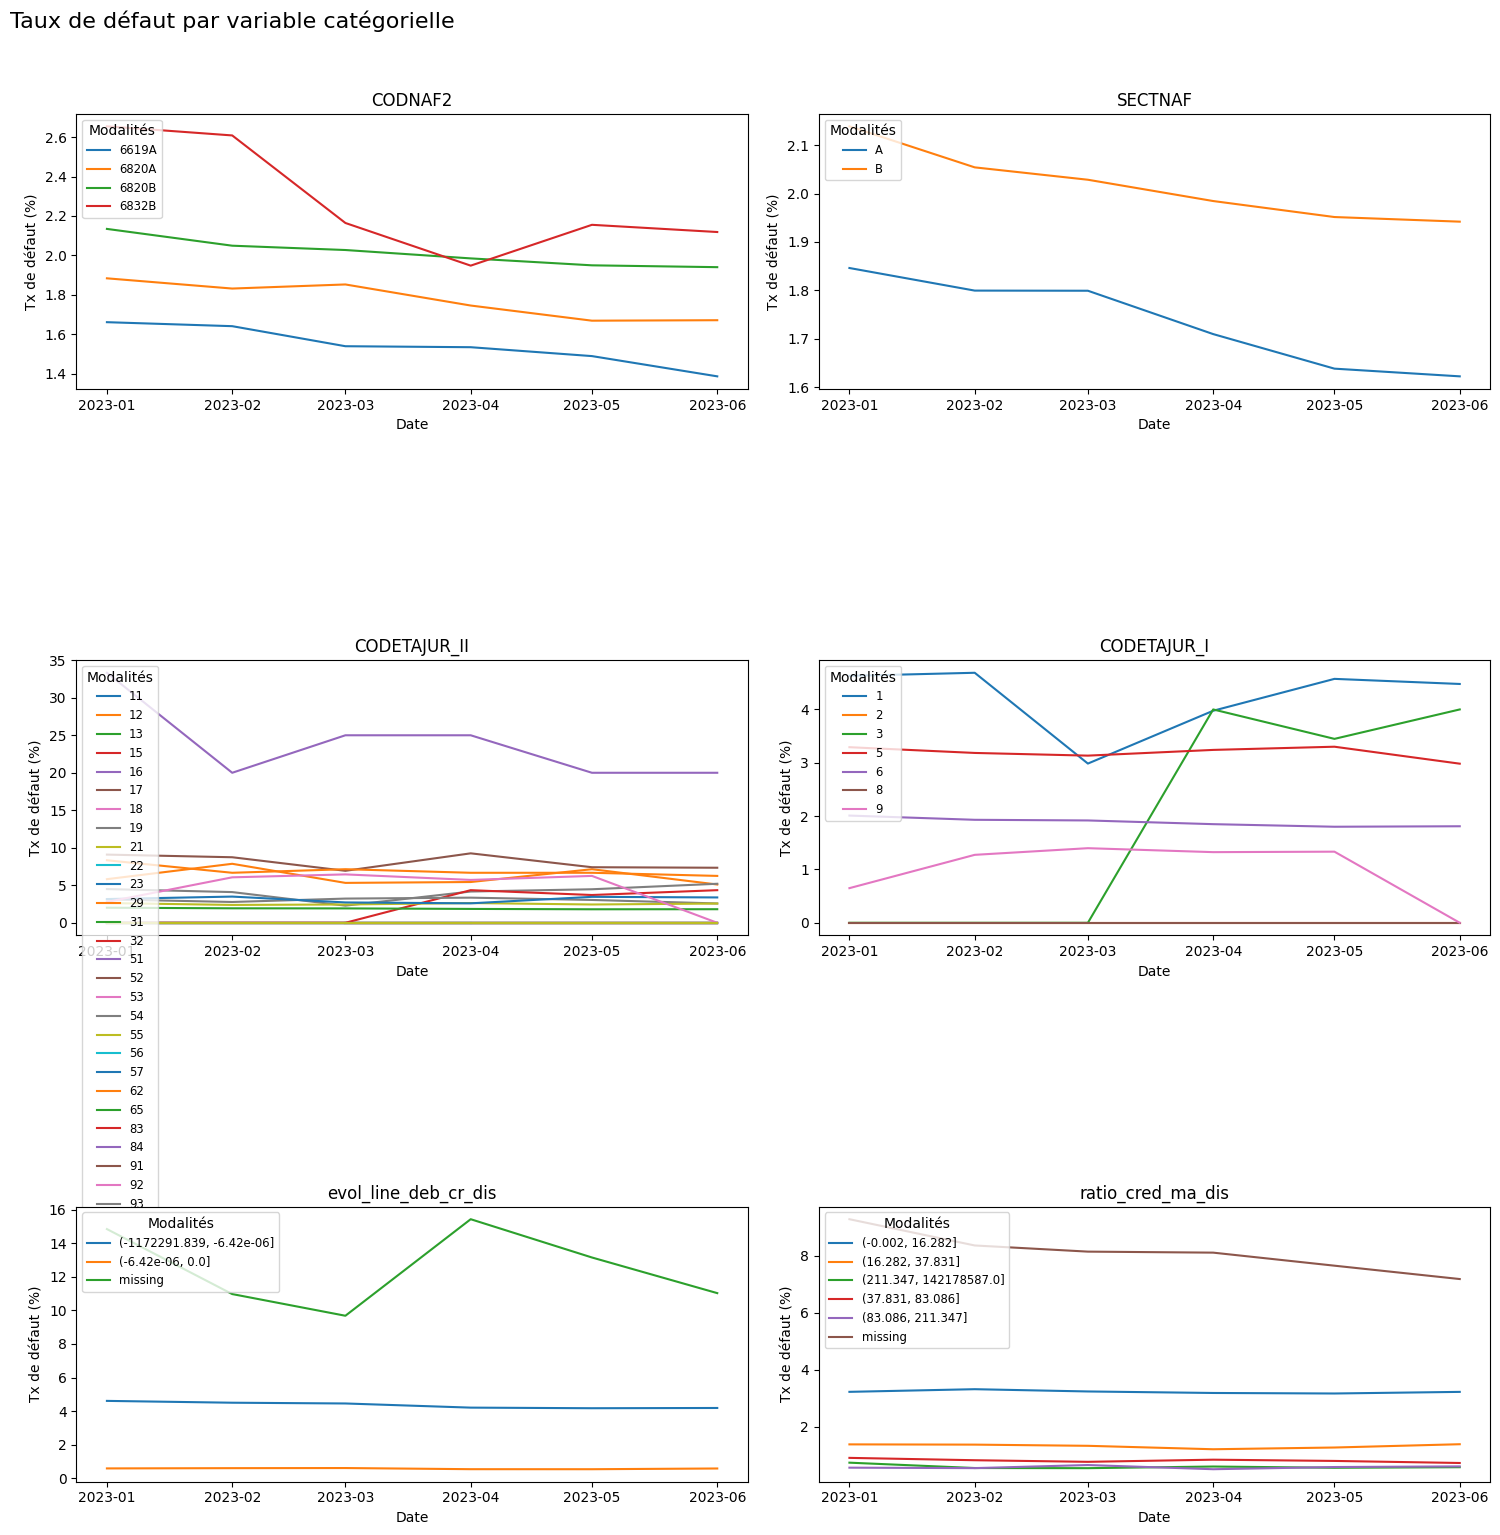

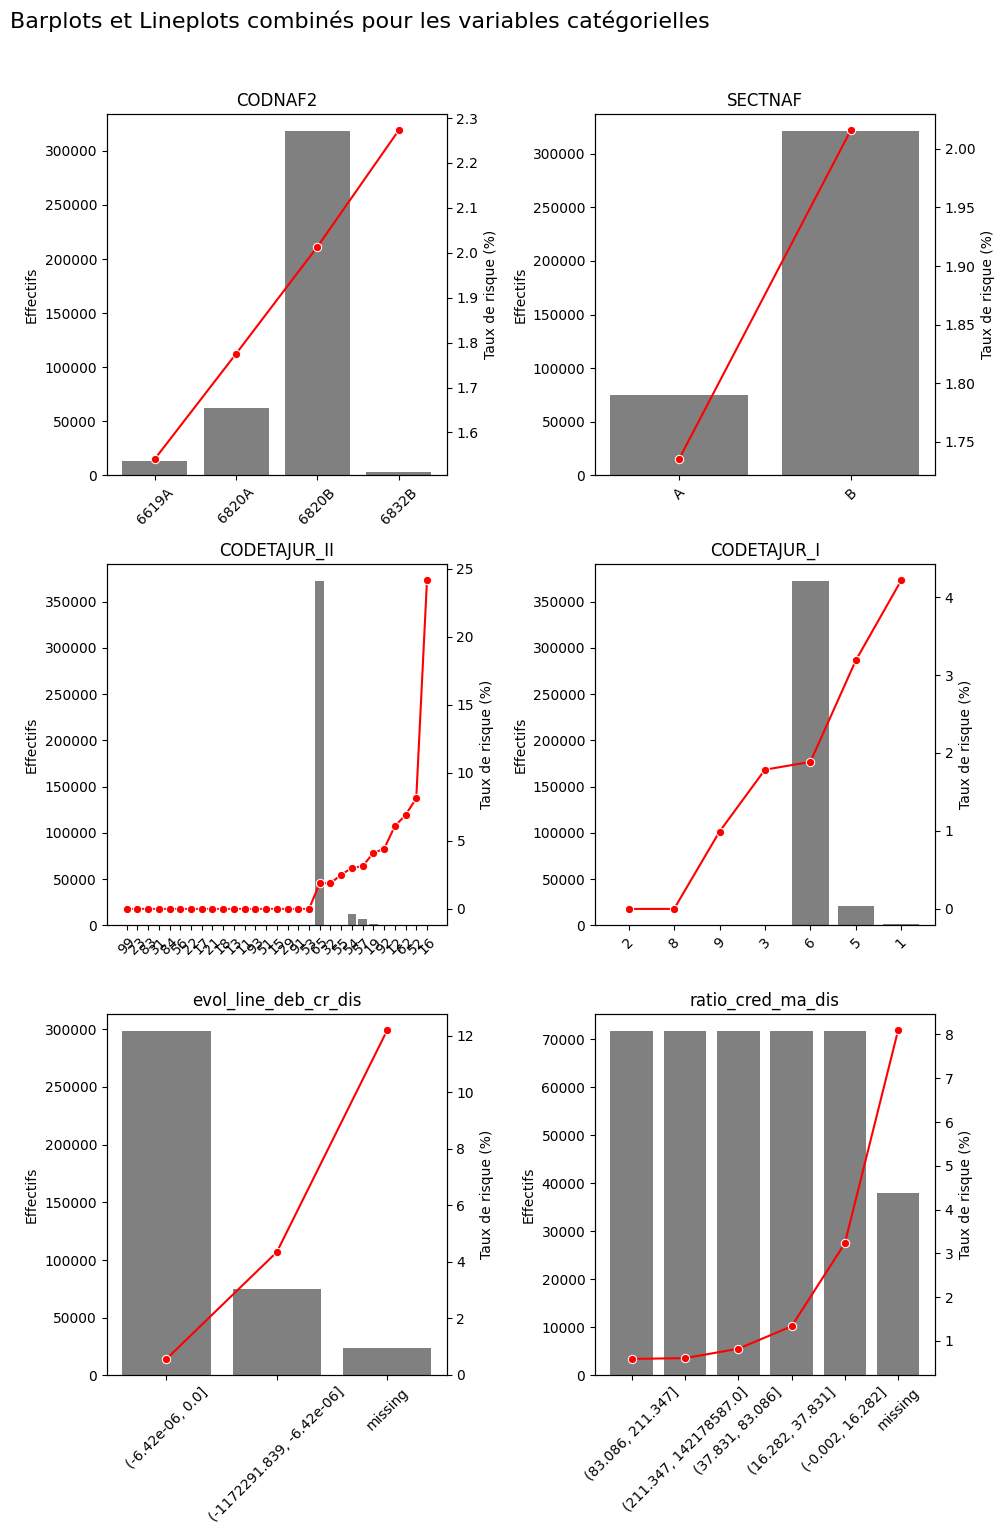

In [83]:
importlib.reload(functions)
functions.plot_cat_vars_distributions(X_train, categorical_vars_train, cols=2)
functions.tx_rsq_par_var(X_train,categorical_vars,date,cible)
functions.combined_barplot_lineplot(X_train, categorical_vars, cible)


On peut voir que le taux de défaut dans le temps est constant dans le temps selon le secteur d'activité. Le secteur d'activité B ( Locations de biens non-résidentiels) est plus risqué que le secteur d'activité A ( Locations de biens résidentiels). De plus, au sein même du secteur d'activité B, le taux de défaut est plus élevé pour les SCI avec un code NAF 6832B.

#### II.1.2. Liaisons avec la variable cible

In [85]:
importlib.reload(functions)
cramer_cible_res=functions.compute_cramers_v(X_train, categorical_vars,cible).sort_values(by = "Cramer_V", ascending=True).round(3)

In [86]:
categorical_vars

['CODNAF2',
 'SECTNAF',
 'CODETAJUR_II',
 'CODETAJUR_I',
 'evol_line_deb_cr_dis',
 'ratio_cred_ma_dis']

Text(0.5, 1.0, 'Variables catégorielles dépendantes de la variable cible')

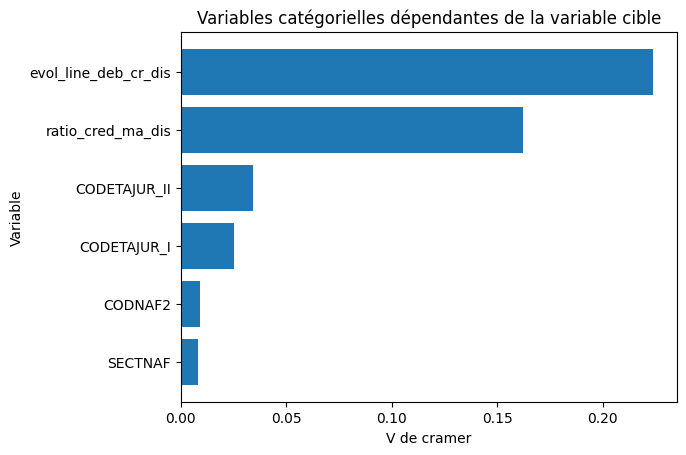

In [103]:
plt.barh(cramer_cible_res['Columns'], cramer_cible_res["Cramer_V"])

# Ajoutez des étiquettes et un titre
plt.xlabel('V de cramer')
plt.ylabel('Variable')
plt.title('Variables catégorielles dépendantes de la variable cible')


Le secteur d'activité n'est pas corrélé à la variable cible. En effet, pour les deux segmentations du code NAF, on obtient un V de cramer inferieur à 1%.
Attention, il y a également un déséquilibre au sein de la variable cible. Il ne faudrait donc pas se fier à la grandeur du v de cramer pour juger de la liaison entre la variable cible et la variable explicative, mais regarder l'ordre de correlation et potentiellement appliquer une méthode par le coude.

#### II.1.3. Liaisons entre les variables catégorielles


In [87]:
importlib.reload(functions)
p_value_df,cramer_v_df=functions.stats_liaisons_var_quali(X_train,categorical_vars)
np.fill_diagonal(cramer_v_df.values, 1)

<Axes: >

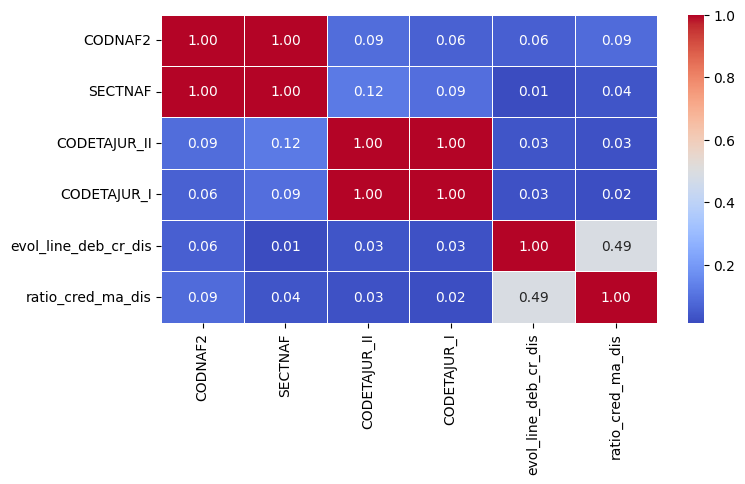

In [88]:
# Créer la heatmap
plt.figure(figsize=(8, 4))  # Vous pouvez ajuster la taille de la figure si nécessaire
sns.heatmap(cramer_v_df.astype(float), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

Sans surprise, les variables créées à partir du code naf et le code d'activité insee sont très correlées avec les variables sources.. Il faudrait peut-être garder la variable secteur d'activité bien que la moins corrélée avec la variable cible car elle ne présente pas d'inversion de risque et les taux de défauts par modalité sont plus ou moins stables dans le temps. De plus, on va préférer garder la variable CODETAJUR aggrégré au niveau I car elle a moins de modalités, bien qu'elle soit moins corrélée avec la variable cible. De plus, la variable CODETAJUR, bien qu'elle soit plus granuilaire, on notre des apparitions et des disparitet des apparitions de modalités au fil du temps.

In [89]:
signif_vars_cat = [ 'SECTNAF', 'CODETAJUR_I', 'evol_line_deb_cr_dis','ratio_cred_ma_dis']

#### II.1.4 Vérification de la proportion d'individus pour chaque modalité pour les variables catégorielles

On souhaite un effectif d'au moins 5% pour chaque modalité. Dans le cas contraire, on regroupe les modalités.

In [111]:
importlib.reload(functions)

functions.test_freq_by_group(X_train, signif_vars_cat)

#On regroupe les modalités par taux de risque décroissant.
res=functions.group_by_rsq(X_train, "CODETAJUR_I", cible) ###Ici, on regroupe les modalités d'une variable catégorielle 
#qui ont une fréquence inférieure à 5% en fonction de leur taux de risque moyen.
result=functions.discretize_by_groups(X_train, "CODETAJUR_I", res,date,cible,'key')  ### On créé une nouvelle avec 
##Extension dis dont les modalités ont des effectifs au moins == à 5%.

             Frequence  Taux de risque
CODETAJUR_I                           
1             0.004967        0.042153
5             0.052625        0.031878
6             0.938977        0.018860
3             0.000424        0.017857
9             0.002291        0.009912
2             0.000674        0.000000
8             0.000043        0.000000


In [112]:
res

[['1', '5'], ['6', '3', '9', '2', '8']]

In [113]:
result.columns

Index(['DDefaut_NDB', 'datdelhis', 'key', 'CODETAJUR_I', 'CODETAJUR_I_dis'], dtype='object')

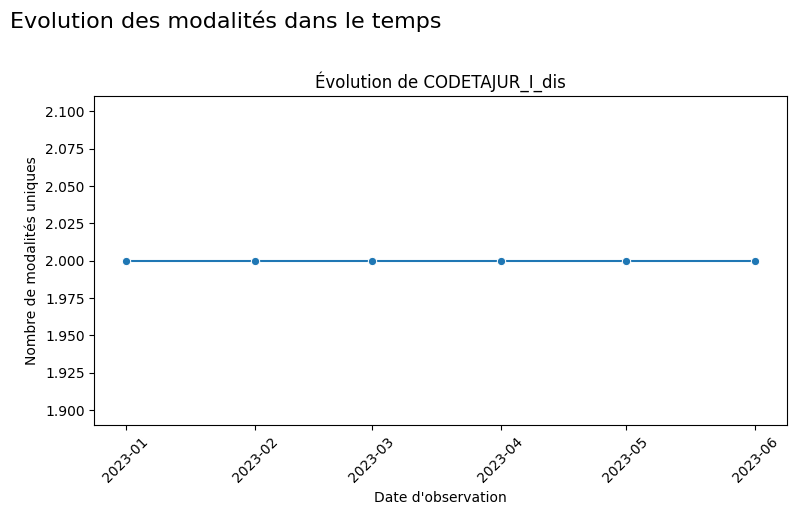

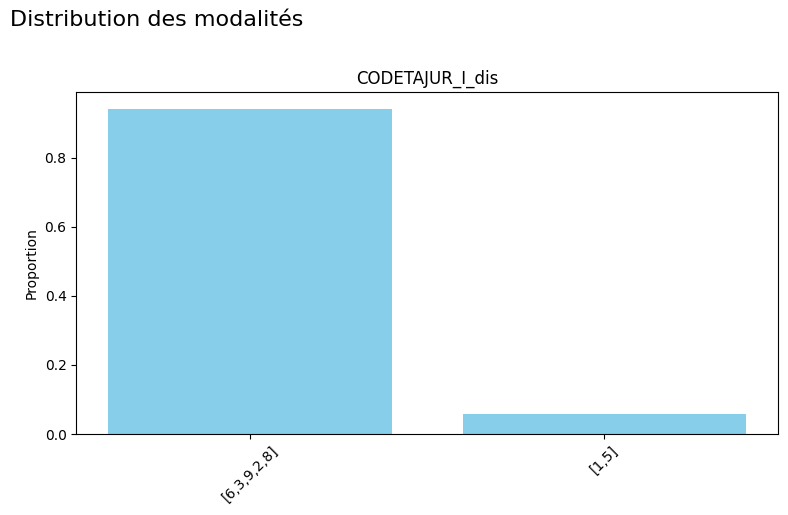

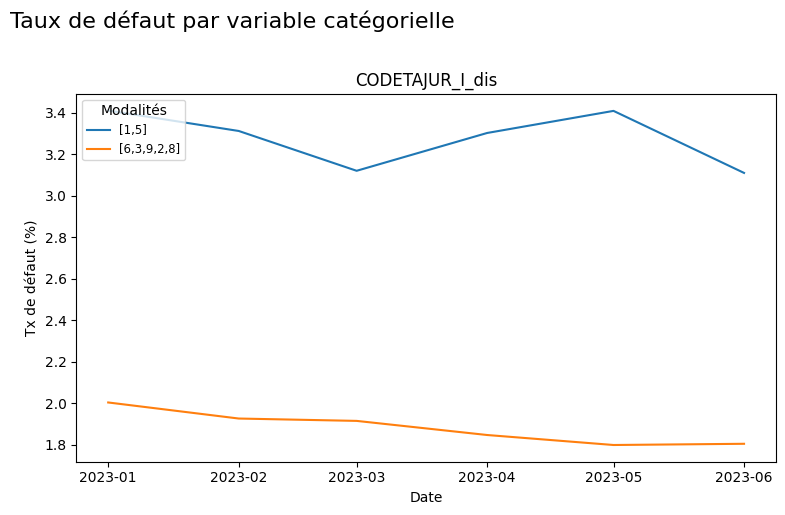

In [114]:
###ON vérifie si notre nouvelle modalité est fiable

importlib.reload(functions)
functions.plot_modalities_over_time(result, "datdelhis", ['CODETAJUR_I_dis'])
functions.plot_cat_vars_distributions(result, ['CODETAJUR_I_dis'], cols=2)
functions.tx_rsq_par_var(result,['CODETAJUR_I_dis'],date,cible)

In [109]:
result['CODETAJUR_I_dis'] = result['CODETAJUR_I_dis'].astype('category')

# Si la colonne est de type catégoriel
print(result['CODETAJUR_I_dis'].cat.categories)


Index(['[1,5]', '[6,3,9,2,8]'], dtype='object')


In [116]:
# Fusionner les deux DataFrames sur la colonne 'key'
X_train_combined= pd.merge(X_train, result[['CODETAJUR_I_dis', 'key']], on='key', how='inner')

# Optionnel : vérifier la taille du DataFrame fusionné
print("Taille du DataFrame fusionné :", X_train_combined.shape)


Taille du DataFrame fusionné : (396411, 53)


In [117]:
X_train = X_train_combined

In [121]:
#### Les variables catégorielles retenues après traitement sont essentiellement:

signif_vars_cat_dis = [ 'SECTNAF', 'CODETAJUR_I_dis', 'evol_line_deb_cr_dis','ratio_cred_ma_dis']

### II.2. Variables continues

#### II.2.1 Statistiques descriptitves univariées des variables continues
Analyse visuelles des distributions

In [126]:
## Date d'entrée en relation avec LCL (DATRLNORG)
#df['DATRLNORG'] = df['DATRLNORG'].astype('int').astype('str')

# Conversion en format datetime (format YYYYMMDD)
#df['DATRLNORG'] = df.to_datetime(df['DATRLNORG'], format='%Y%m%d')
df['DATRLNORG'].head()

0   1995-01-24
1   1991-10-11
2   1981-10-22
3   1969-10-01
4   1981-03-26
Name: DATRLNORG, dtype: datetime64[ns]

In [139]:
# Conversion des valeurs float en string et suppression de la partie décimale
X_train['DATRLNORG'] = X_train['DATRLNORG'].astype('int').astype('str')

# Conversion en format datetime (format YYYYMMDD)
X_train['DATRLNORG'] = pd.to_datetime(X_train['DATRLNORG'], format='%Y%m%d')

# Affichage des premières lignes pour vérifier
print(X_train['DATRLNORG'].head())



0   2020-04-18
1   2019-10-19
2   1998-01-01
3   2020-07-28
4   2014-01-22
Name: DATRLNORG, dtype: datetime64[ns]


In [142]:
# Calculer la différence entre les deux dates (en jours)
X_train['duration_days'] = (X_train['datdelhis'] - X_train['DATRLNORG']).dt.days

# Convertir la différence en mois (approximativement en divisant par 30.44 jours par mois)
X_train['duration_months'] = (X_train['duration_days'] / 30).round()

# Afficher les résultats
#print(X_train[['datdelhis', 'DATRLNORG', 'duration_months']].head())

# Calculer la différence entre 'duration_months' et 'ANCIENNETE'
X_train['difference_months'] = X_train['duration_months'] - X_train['ANCIENNETE']

# Afficher la différence
print(X_train[['duration_months', 'ANCIENNETE', 'difference_months']].head(10))

X_train['difference_months'].describe()

###ça ne coincide pas necessairement, on va essayer de modeliser ainsi et un choix éventuel se fera au niveau de la selection des variables


   duration_months  ANCIENNETE  difference_months
0             34.0          34                0.0
1             40.0          40                0.0
2            306.0         302                4.0
3             30.0          30                0.0
4            111.0         110                1.0
5             38.0          38                0.0
6            232.0         229                3.0
7             76.0          76                0.0
8            295.0         291                4.0
9              4.0           4                0.0


count    396411.000000
mean          1.354614
std           7.077490
min        -584.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: difference_months, dtype: float64

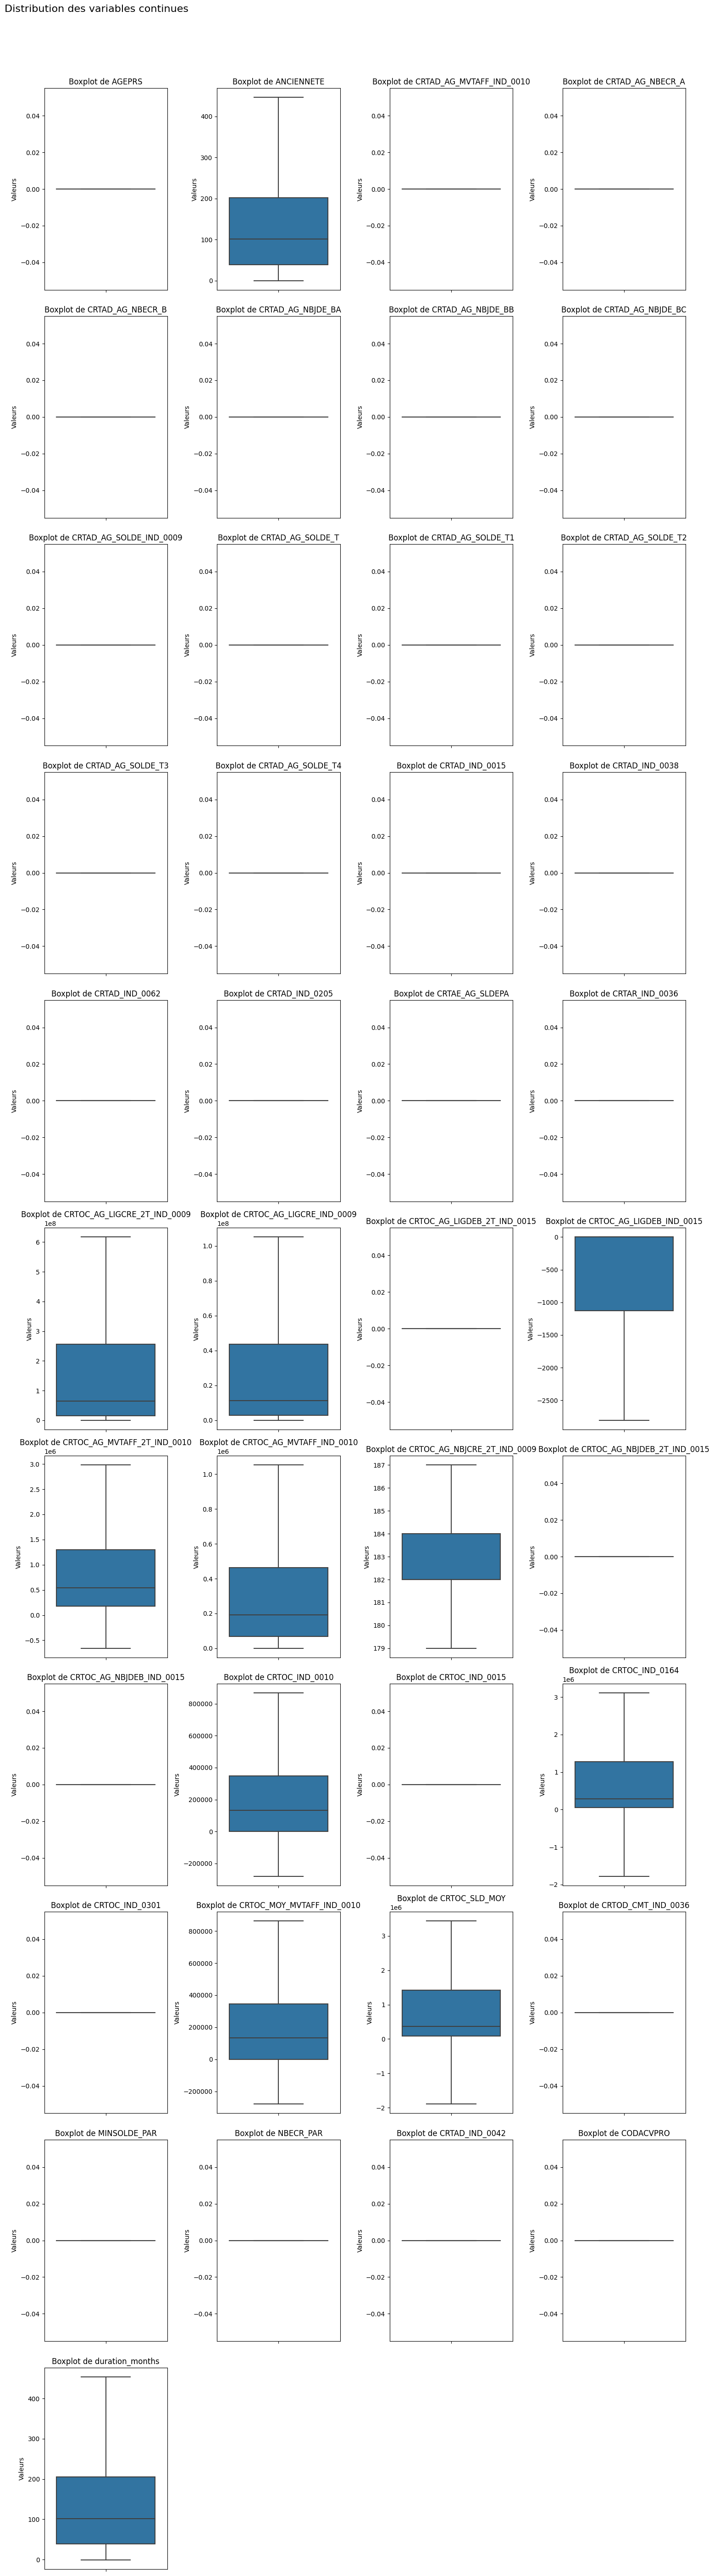

In [146]:
importlib.reload(functions)
cont_vars = [var for var in pre_cont_vars if var != 'CODETAJUR']
cont_vars.remove('DATRLNORG')

cont_vars.append('duration_months')


functions.plot_boxplots(X_train,cont_vars,cols=4)

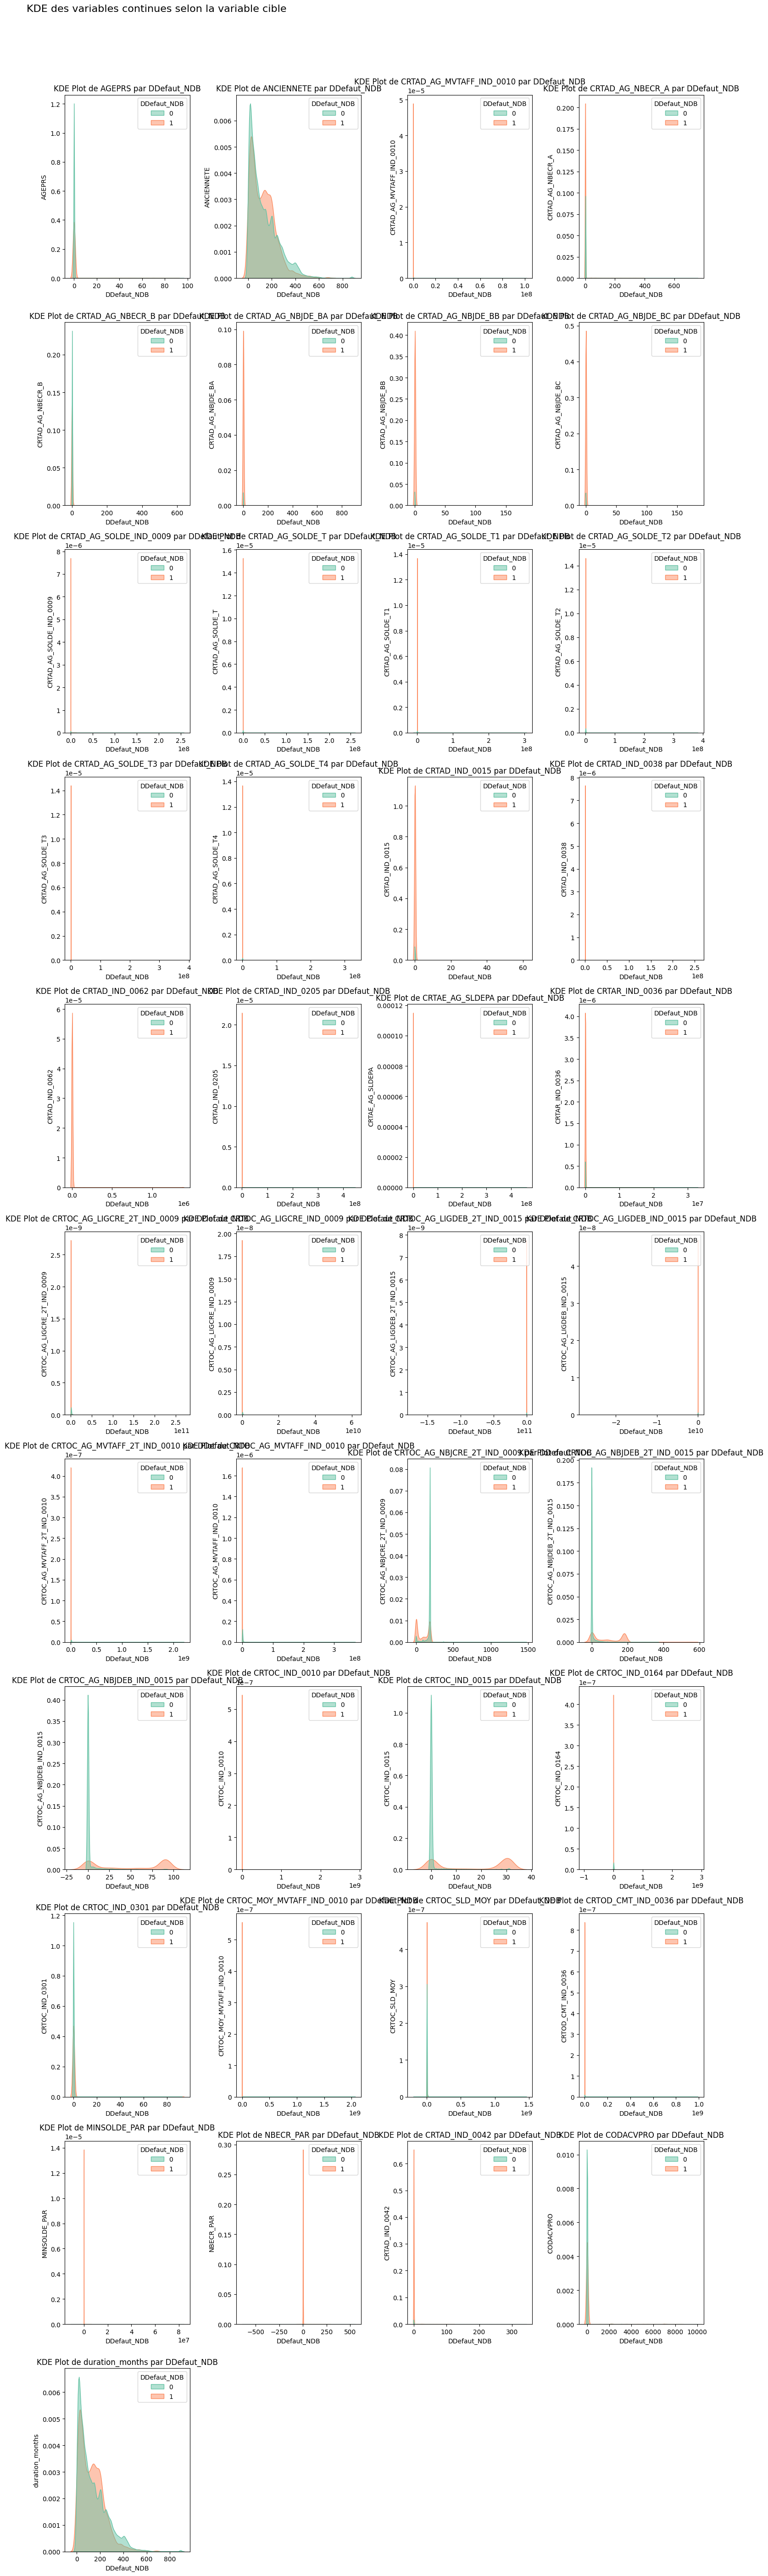

In [147]:
importlib.reload(functions)

functions.plot_kde_by_target(X_train, cont_vars, cible, cols=4)
# KDE plot

#### II.2.2 Liaisons avec la variable cible

Utiliser des indicateurs tels que le HSIC, information mutuelle, en plus des indicateurs usuelles.

Question à poser : En regréssion logistique, on ne souhaite que chasser les liaisons monotones et linéaires entre les variables explicatives.

/!\ Attention à la définition de seuil pour ces indicateurs.

#### II.2.2.1. relation enre les variables continues et la vatiable cible

In [148]:
### La taille des echantillons etant relativement grande à l'intérieur de chaque groupe (ceux en défaut et ceux qui ne le sont pas) 
### l'hypothèse de normalité est moins préoccupante dans le cadre d'un test d'ANOVA dû au Théoreme central limite

### Pour les variables continues contenues dans cont_vars, nous allons effectuer un test d'ANOVA pour vérifier si les moyennes des groupes sont égales

importlib.reload(functions)
anova_results=functions.perform_anova(X_train, cont_vars, cible).sort_values(by = "Stat", ascending=True).round(3)

15

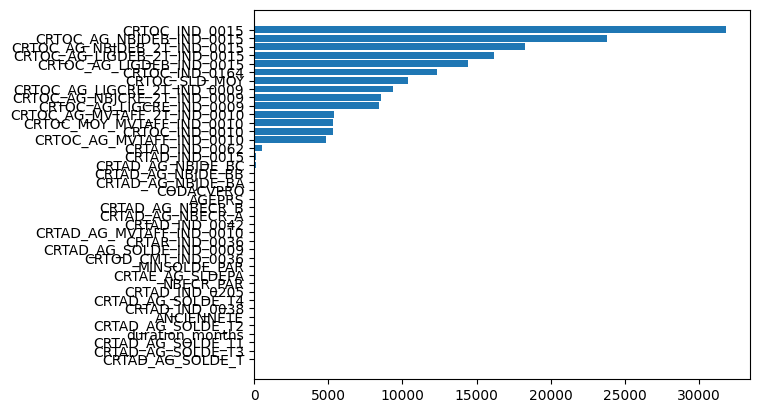

In [149]:
plt.barh(anova_results['Columns'][1:], anova_results['Stat'][1:])
signif_conti_var_anova=anova_results[anova_results['Stat']>150]['Columns']

len(signif_conti_var_anova)

In [ ]:
# Affichons les statistiques de test des variables continues rangées par ordre decroissant
"""results_df = pd.DataFrame(anova_results)
    
# Trier par F-statistic décroissante
results_df = results_df.sort_values(by="F-Statistic", ascending=False).reset_index(drop=True)
    
# Plot des résultats
plt.figure(figsize=(10, 6))
sns.barplot(x="F-Statistic", y="Variable", data=results_df, palette="viridis")
plt.title("ANOVA: F-Statistics by Variable", fontsize=16)
plt.xlabel("F-Statistic", fontsize=14)
plt.ylabel("Variables", fontsize=14)
plt.tight_layout()
plt.show()"""

In [150]:
#### Le kruskall Wallis etant un test non parametrique, il est plus robuste que l'ANOVA en cas de non respect de l'hypothèse de normalité
###Mettons en place un test de Kruskall Wallis pour vérifier si les distributions des variables continues sont les mêmes pour les différentes modalités de la variable cible

importlib.reload(functions)
kruskal_results=functions.perform_kruskal_wallis(X_train, cont_vars, cible).sort_values(by = "Stat", ascending=True).round(3)
kruskal_results

,Columns,Stat,Pvalue
32,CRTOC_IND_0301,0.000,0.983
9,CRTAD_AG_SOLDE_T,0.042,0.838
12,CRTAD_AG_SOLDE_T3,0.194,0.660
10,CRTAD_AG_SOLDE_T1,0.254,0.615
40,duration_months,0.457,0.499
11,CRTAD_AG_SOLDE_T2,0.577,0.448
1,ANCIENNETE,0.585,0.444
15,CRTAD_IND_0038,1.004,0.316
13,CRTAD_AG_SOLDE_T4,1.486,0.223
17,CRTAD_IND_0205,2.106,0.147


15
16                 CRTAD_IND_0062
25       CRTOC_AG_MVTAFF_IND_0010
29                 CRTOC_IND_0010
33      CRTOC_MOY_MVTAFF_IND_0010
24    CRTOC_AG_MVTAFF_2T_IND_0010
21       CRTOC_AG_LIGCRE_IND_0009
26    CRTOC_AG_NBJCRE_2T_IND_0009
20    CRTOC_AG_LIGCRE_2T_IND_0009
34                  CRTOC_SLD_MOY
31                 CRTOC_IND_0164
23       CRTOC_AG_LIGDEB_IND_0015
22    CRTOC_AG_LIGDEB_2T_IND_0015
27    CRTOC_AG_NBJDEB_2T_IND_0015
28       CRTOC_AG_NBJDEB_IND_0015
30                 CRTOC_IND_0015
Name: Columns, dtype: object


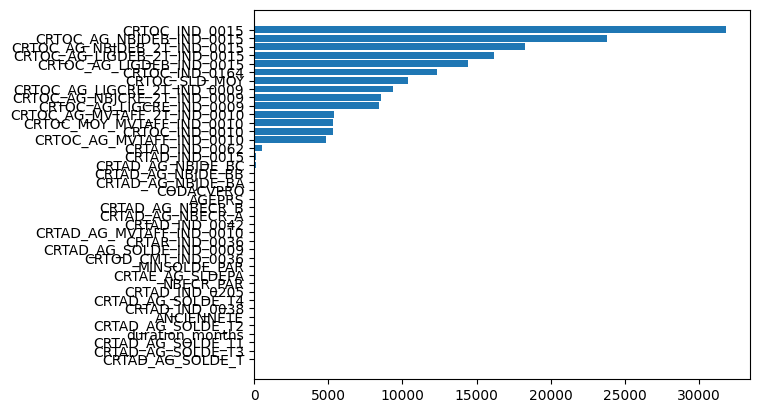

In [152]:
plt.barh(kruskal_results['Columns'][1:], kruskal_results['Stat'][1:])
signif_conti_var_kruskal=kruskal_results[kruskal_results['Stat']>150]['Columns']
print(len(signif_conti_var_kruskal))
print(signif_conti_var_kruskal)

In [153]:
### le nombre de variables retenu par le test de Kruskall wallis
len(kruskal_results.T.columns)



41

#### II.2.2 Liaisons entre les variables continues selectionnées

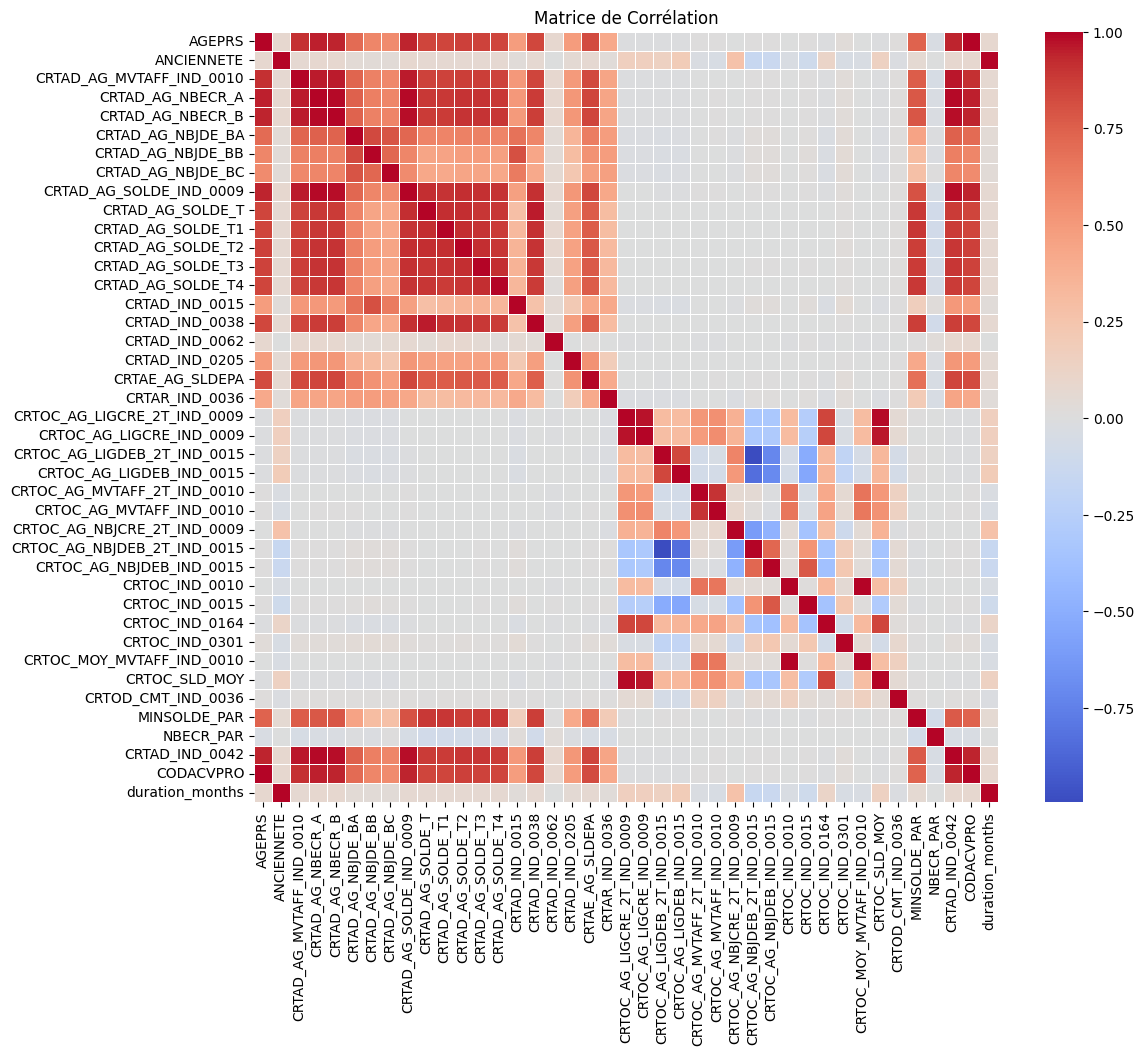

In [154]:
spearman_res=X_train[cont_vars].corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_res,cmap='coolwarm', linewidths=.5)

# Ajoutez un titre
plt.title('Matrice de Corrélation')

# Affichez le graphique
plt.show()

#### II.2.3 Discrétisation des variables continues

In [155]:
importlib.reload(functions)
if __name__ == '__main__':
    max_intervals = 4
    obj = functions.Discretization()
    intervals_by_variable = []  # Liste pour stocker les intervalles par variable
    
    for colName in ["CRTOC_AG_NBJDEB_IND_0015","CRTOC_AG_NBJDEB_2T_IND_0015"]:
        print('\nInterval for', colName)
        # Générer les intervalles
        intervals = obj.get_chimerge_intervals(X_train, colName, cible, max_intervals)
        
        # Ajouter les intervalles à la liste avec le nom de la variable
        intervals_by_variable.append({
            'variable': colName,
            'intervals': intervals
        })
        
        print(tabulate([[intervals]], tablefmt='fancy_grid'))

Data discretization process started

Interval for CRTOC_AG_NBJDEB_IND_0015
 Min chi square value is 596.8140537383696
╒═══════════════════════════════════════╕
│ [[0, 3], [4, 64], [65, 88], [89, 92]] │
╘═══════════════════════════════════════╛

Interval for CRTOC_AG_NBJDEB_2T_IND_0015
 Min chi square value is -188392271.57199517
╒══════════════════════════════════════════════╕
│ [[0, 64], [65, 151], [152, 177], [178, 552]] │
╘══════════════════════════════════════════════╛


Stabilité des variables discrétisées

In [ ]:
importlib.reload(functions)
dis_data,new_vars=functions.discretize_with_intervals(X_train, intervals_by_variable,date,cible)

dis_data.head()
functions.tx_rsq_par_var(dis_data,new_vars,date,cible)

### III. Construction du modèle

#### III.1. Régression logistique

Regression lasso, ridge, elastic, méthode stepwise, 